In [1]:
from graspologic import embed
import numpy as np
import pandas as pd
import scanpy as sc
from graspologic.embed.ase import AdjacencySpectralEmbed
from graspologic.embed.lse import LaplacianSpectralEmbed
from graspologic.embed import select_dimension
from graspologic.utils import is_symmetric, is_unweighted, largest_connected_component, symmetrize
from graspologic.plot import pairplot
from graspologic.cluster import AutoGMMCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.stats import spearmanr
import os
from scipy.io import mmread
import matplotlib.pyplot as plt
import seaborn as sns
context = sns.plotting_context(context="talk", font_scale=0.8)
sns.set_context(context)


In [2]:
# import intermediary results from R
sample_id = 's6'
# SCT_residuals = pd.read_csv("Brainseq/"+sample_id+"/SCT_residuals.csv", index_col=0)
# SCT_residuals = SCT_residuals.to_numpy().T

# meta = pd.read_csv("Brainseq/"+sample_id+"/SCT_log_trans_counts.csv", index_col=0)
# SCT_log_trans_counts = meta.to_numpy().T
SCT_log_trans_counts = mmread("Brainseq/"+sample_id+"/SCT_log_trans_counts.mtx").tocsr()

# SCT_counts = pd.read_csv("Brainseq/"+sample_id+"/SCT_counts.csv", index_col=0)
# SCT_counts = SCT_counts.to_numpy().T

pca_embed = pd.read_csv("Brainseq/"+sample_id+"/pca_embed.csv", index_col=0)
pca_embed = pca_embed.to_numpy()

# umap_embed = pd.read_csv("Brainseq/"+sample_id+"/umap_embed.csv", index_col=0)
# umap_embed = umap_embed.to_numpy()

clus = pd.read_csv("Brainseq/"+sample_id+"/clusters.csv", index_col=0)
clus = clus.to_numpy().reshape(-1,)

gene_names = pd.read_csv("Brainseq/"+sample_id+"/gene_names.csv", index_col=0).set_index(['x'])


In [3]:
# kNN graph using Spearman correlation

k = 20
pca_dim = 40
def spearmancorr(x):
    rho, _ = spearmanr(x, axis=1)
    return 1-np.absolute(rho)

nn = NearestNeighbors(n_neighbors=k, metric='precomputed')
nn.fit(spearmancorr(pca_embed[:, :pca_dim]))
adj = nn.kneighbors_graph(n_neighbors=k, mode='connectivity')
adj = np.array(adj.todense())
np.fill_diagonal(adj, 1)
adj = symmetrize(adj)


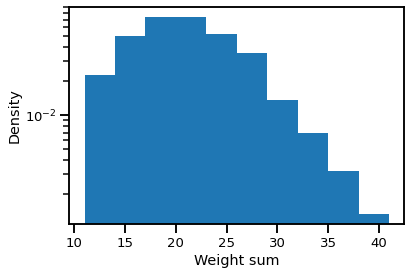

In [4]:
plt.hist(np.sum(adj, axis=0), log=True, density=True)
plt.xlabel('Weight sum')
plt.ylabel('Density')
plt.show()


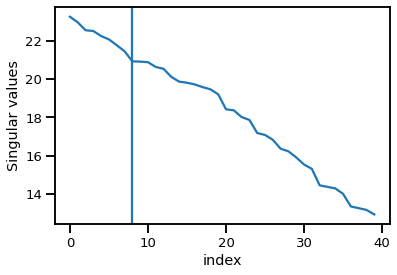

In [5]:
# spectral embedding

ase = AdjacencySpectralEmbed(40)
ase.fit(adj)
singular_values = ase.singular_values_
fig,ax = plt.subplots(1)
ax.plot(range(len(singular_values)), singular_values)

ase = AdjacencySpectralEmbed()
embedding = ase.fit_transform(adj)
ax.axvline(embedding.shape[1])
ax.set(xlabel='index', ylabel='Singular values')
plt.show()


In [6]:
# Gaussian mixture modeling

n_comp = int(max(clus)+1)
agg = AutoGMMCluster(min_components=n_comp, max_components=n_comp)
pred = agg.fit_predict(embedding)
print(adjusted_rand_score(pred, clus))


0.456964174107212


In [7]:
print(embedding.shape)

(1762, 8)


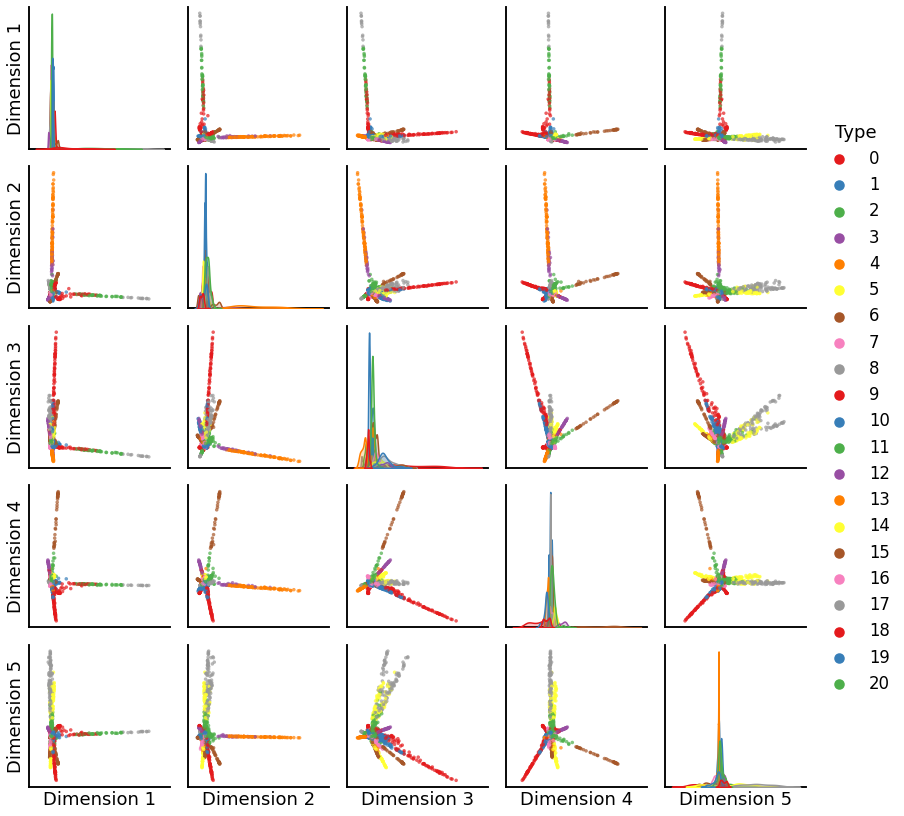

In [8]:
pairplot(embedding[:,:5], pred)
plt.savefig('Brainseq/'+sample_id+'/GMM-ASE'+str(embedding.shape[1])+'-spearman-knn20-pca40.pdf',
    transparent=False, facecolor='white', bbox_inches = "tight", dpi=300)


In [9]:
# marker genes for different cell types

feature_id = {}
# feature_names_all = [["brp", "nSyb", "elav", "Syt1","CadN"],
#     ["repo", "alrm", "Eaat1", "Gs1", "MFS9", "bnb","myr-GFP-p10", "nls-tdTomato"],
#     ["N", "dpn", "Pen", "mira"]
#     ]
feature_names_all = [
    ["brp","nSyb","elav","Syt1","CadN","jeb","IA-2","Rdl","nrv-3","VGlut","VAChT",
     "Gad1","Vmat","jim","myr-GFP-p10","nls-tdTomato"],  # neuron
    ["repo", "hoe1","swim","vir-1","wrapper","alrm","Eaat1","Gat","Gs30","MFS9",
     "bnb","sli"],  # glia
    ["N","dpn","Pen","mira","Grh","Kr"],  # NPCs
    ["hdc","unk","sn","pho"],  # adult neurons

]
for i in range(len(feature_names_all)):
    feature_id[i] = []
    for j in feature_names_all[i]:
        try:
            feature_id[i].append(gene_names.index.get_loc(j))
        except:
            continue


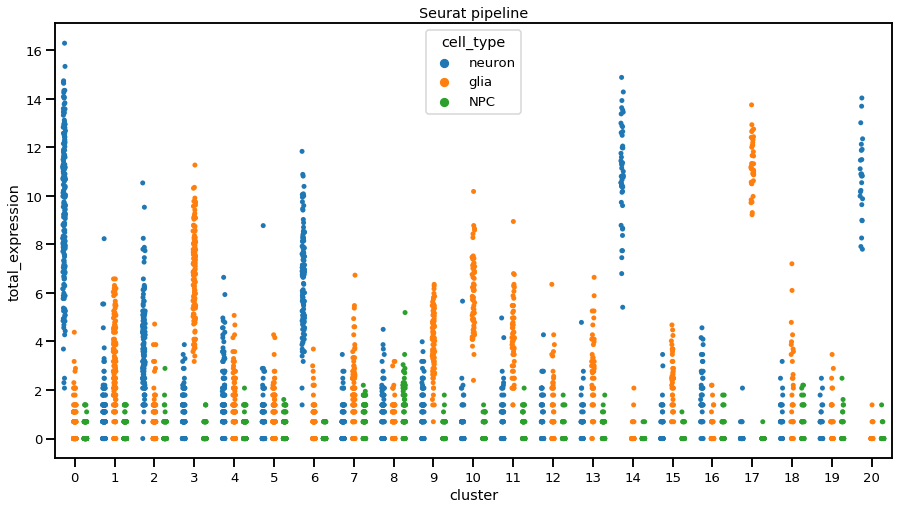

In [10]:
# total expression level of marker genes for each cell type

expn_overall = SCT_log_trans_counts.copy().T
expn_all_cell_types = np.vstack((np.array(np.sum(expn_overall[:,feature_id[0]], axis=1)),
    np.array(np.sum(expn_overall[:,feature_id[1]], axis=1)),
    np.array(np.sum(expn_overall[:,feature_id[2]], axis=1)))).reshape(-1,)

df = pd.DataFrame(data={
    'total_expression': expn_all_cell_types,
    # 'cluster': np.hstack((pred, pred, pred)),
    'cluster': np.hstack((clus, clus, clus)),
    'cell_type': np.repeat(['neuron', 'glia', 'NPC'], len(clus))
})

fig,ax = plt.subplots(1, figsize=(15,8))
sns.stripplot(data=df, x='cluster', y='total_expression', hue='cell_type',
    dodge=True, ax=ax)
ax.set_title('Seurat pipeline')
# ax.set_title('GMM o ASE o Spearman knn')
plt.show()


In [11]:
# new clustering was exported to R to identify gene markers
pred_df = pd.read_csv("Brainseq/"+sample_id+"/clusters.csv", index_col=0).copy()
pred_df['seurat_clusters'] = pred
pred_df.to_csv("Brainseq/"+sample_id+"/new_clus.csv")


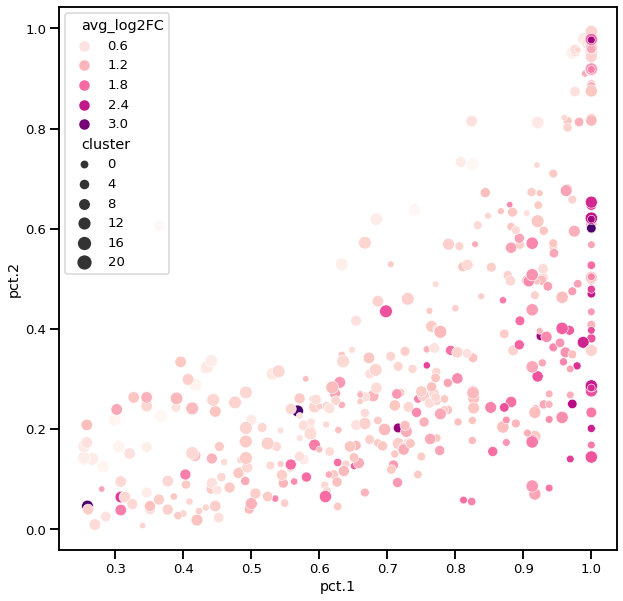

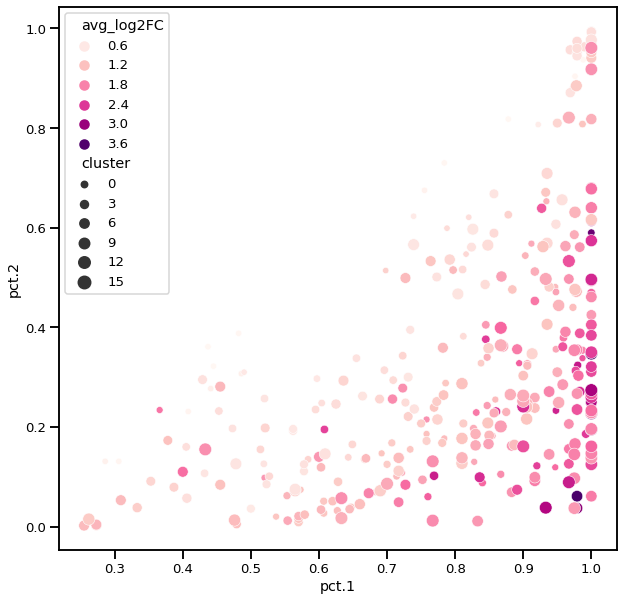

In [12]:
top20 = pd.read_csv("Brainseq/"+sample_id+"/marker_genes_new_clus.csv", index_col=0)
fig,ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(data=top20, x='pct.1', y='pct.2', hue='avg_log2FC', size='cluster', palette='RdPu')
plt.show()

# gene markers based on clusterings generated by seurat pipeline
top20 = pd.read_csv("Brainseq/"+sample_id+"/marker_genes_seurat_clus.csv", index_col=0)
fig,ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(data=top20, x='pct.1', y='pct.2', hue='avg_log2FC', size='cluster', palette='RdPu')
plt.show()




